In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_processing.load_sqlite as load_sql
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Predicting Success with Frequency Encoding

In [86]:
df = load_sql.fetch_movie_rating_features()
df.head()

,movie_id,vote_average,title,release_date,runtime,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,director_ids,writer_ids,company_ids,genre_ids
0,2,7.113,Ariel,1988-10-21,73,None,None,None,0,None,None,2303,"18,35,80,10749"
1,3,7.300,Shadows in Paradise,1986-10-17,74,None,None,None,0,None,None,2303,"18,35,10749"
2,5,5.858,Four Rooms,1995-12-09,98,3129,"3129,3130","3129,3130,3131,3124,2555",28,"138,2294,3110,3111","138,2294,3110,3111","14,59","35,80"
3,6,6.500,Judgment Night,1993-10-15,109,2880,"2880,9777","2880,9777,5724,10822,12799",31,2042,"52035,52035,1088307","33,182,1644","28,53,80"
4,11,8.200,Star Wars,1977-05-25,121,2,"2,3","2,3,4,5,12248",104,1,1,"1,25","12,28,878"


In [87]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26204 entries, 2 to 44520
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie_id          26204 non-null  int64  
 1   vote_average      26204 non-null  float64
 2   title             26204 non-null  object 
 3   release_date      26204 non-null  object 
 4   runtime           26204 non-null  int64  
 5   top_cast_id       26204 non-null  object 
 6   top_2_cast_ids    26204 non-null  object 
 7   top_5_cast_ids    26204 non-null  object 
 8   num_cast_members  26204 non-null  int64  
 9   director_ids      26204 non-null  object 
 10  writer_ids        26204 non-null  object 
 11  company_ids       26204 non-null  object 
 12  genre_ids         26204 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 2.8+ MB


In [88]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_date'] = df['release_date'].astype(int) / 10**9  # Unix timestamp in seconds

In [89]:
df["successful"] = (df["vote_average"] > 7.0).astype(int) 
df.columns

Index(['movie_id', 'vote_average', 'title', 'release_date', 'runtime',
       'top_cast_id', 'top_2_cast_ids', 'top_5_cast_ids', 'num_cast_members',
       'director_ids', 'writer_ids', 'company_ids', 'genre_ids', 'successful'],
      dtype='object')

In [90]:
df.corr(numeric_only=True)["successful"].sort_values(ascending=False)

successful          1.000000
vote_average        0.643150
runtime             0.157104
num_cast_members    0.100434
movie_id            0.037698
release_date       -0.000986
Name: successful, dtype: float64

In [91]:
# Split the dataset first
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.columns

Index(['movie_id', 'vote_average', 'title', 'release_date', 'runtime',
       'top_cast_id', 'top_2_cast_ids', 'top_5_cast_ids', 'num_cast_members',
       'director_ids', 'writer_ids', 'company_ids', 'genre_ids', 'successful'],
      dtype='object')

In [92]:
categorical_cols = ['company_ids', 'top_cast_id', 'top_2_cast_ids', 'top_5_cast_ids', 'director_ids', 'writer_ids', 'genre_ids']

for col in categorical_cols:
    # Compute frequencies in training data
    freq_map = train_df[col].value_counts().to_dict()
    
    # Map frequencies in both training and test sets
    train_df[col + '_freq'] = train_df[col].map(freq_map)
    test_df[col + '_freq'] = test_df[col].map(freq_map)

    # Fill missing values with a default frequency (e.g., 1)
    train_df[col + '_freq'] = train_df[col + '_freq'].fillna(1)
    test_df[col + '_freq'] = test_df[col + '_freq'].fillna(1)

train_df.corr(numeric_only=True)["successful"].sort_values(ascending=False)

successful             1.000000
vote_average           0.643328
runtime                0.163982
num_cast_members       0.095581
top_5_cast_ids_freq    0.050896
director_ids_freq      0.048338
top_2_cast_ids_freq    0.044961
movie_id               0.032802
writer_ids_freq        0.032210
top_cast_id_freq       0.028011
company_ids_freq       0.006549
genre_ids_freq         0.003351
release_date           0.000718
Name: successful, dtype: float64

In [93]:
# Select features to keep (numeric columns)
features_to_keep = train_df.select_dtypes(include=["float64", "int64"]).columns

# Prepare the training and test data
X_train = train_df[features_to_keep].drop(columns=["vote_average", "successful", "movie_id"])
y_train = train_df["successful"]
X_test = test_df[features_to_keep].drop(columns=["vote_average", "successful", "movie_id"])
y_test = test_df["successful"]

In [94]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42
)

rf.fit(X_train, y_train)

print("Training score:", rf.score(X_train, y_train))
print("Testing score:", rf.score(X_test, y_test))

Training score: 0.8244526069741926
Testing score: 0.8061438656744896


### Which features are most important?

In [95]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head()

,Feature,Importance
1,runtime,0.371235
0,release_date,0.142640
2,num_cast_members,0.125720
9,genre_ids_freq,0.120952
4,top_cast_id_freq,0.062779


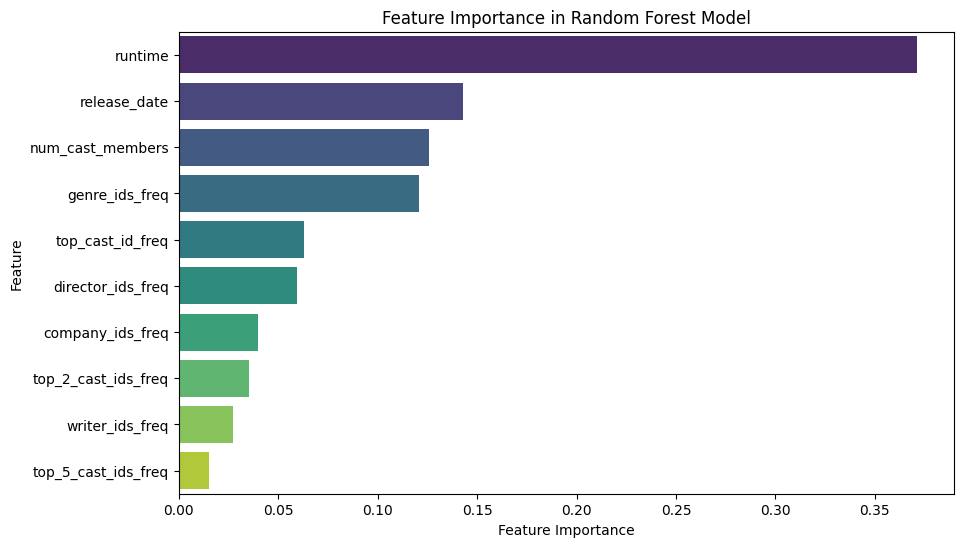

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=feature_importance_df, 
    hue="Feature", 
    palette="viridis", 
    legend=False 
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

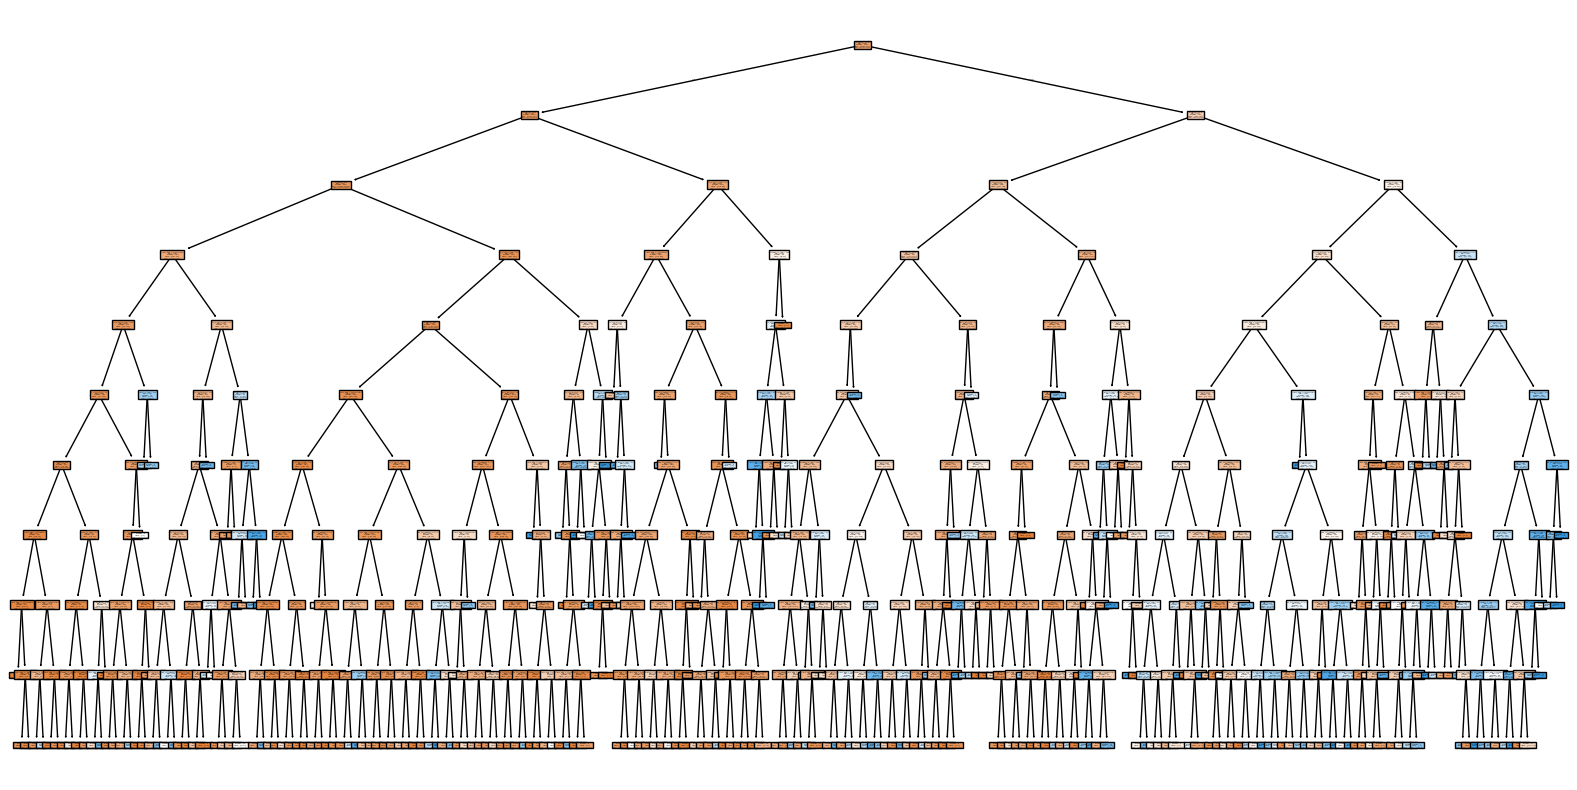

In [76]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
tree_index = 1  # Change this to visualize different trees
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[tree_index], filled=True, feature_names=X_train.columns, class_names=["Not Successful", "Successful"])
plt.show()


## Predict Success using Categorical Scores

In [77]:
lambda_director   = 0.000408
lambda_writers    = 0.000377
lambda_cast_time  = 0.000592
lambda_cast_order = 0.122

df = load_sql.fetch_predict_success_data(lambda_director, lambda_writers, lambda_cast_time, lambda_cast_order)
df.head()

,movie_id,vote_average,title,release_date,runtime,top_cast_id,top_2_cast_ids,top_5_cast_ids,num_cast_members,director_ids,...,Music,Romance,Family,War,TV Movie,director_score,writer_score,cast_score,production_company_score,successful
0,2,7.113,Ariel,593395200.0,73,None,None,None,0,None,...,0,1,0,0,0,6.292833,6.292833,6.292833,6.687600,1
1,3,7.300,Shadows in Paradise,529891200.0,74,None,None,None,0,None,...,0,1,0,0,0,6.292833,6.292833,6.292833,6.512667,1
2,5,5.858,Four Rooms,818467200.0,98,3129,"3129,3130","3129,3130,3131,3124,2555",28,"138,2294,3110,3111",...,0,0,0,0,0,7.333995,7.355491,6.648418,6.302417,0
3,6,6.500,Judgment Night,750643200.0,109,2880,"2880,9777","2880,9777,5724,10822,12799",31,2042,...,0,0,0,0,0,5.882887,6.119896,6.370170,6.376285,0
4,11,8.200,Star Wars,233366400.0,121,2,"2,3","2,3,4,5,12248",104,1,...,0,0,0,0,0,6.782933,6.676182,6.170755,6.623217,1


In [78]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [79]:
for col in categorical_cols:
    # Compute frequencies in training data
    freq_map = train_df[col].value_counts().to_dict()
    
    # Map frequencies in both training and test sets
    train_df[col + '_freq'] = train_df[col].map(freq_map)
    test_df[col + '_freq'] = test_df[col].map(freq_map)

    # Fill missing values with a default frequency (e.g., 1)
    train_df[col + '_freq'] = train_df[col + '_freq'].fillna(1)
    test_df[col + '_freq'] = test_df[col + '_freq'].fillna(1)

features_to_keep = train_df.select_dtypes(include=["float64", "int64"]).columns

In [80]:
# Define features
X_train = train_df[features_to_keep].drop(columns=['vote_average', 'movie_id', 'successful'])
X_test = test_df[features_to_keep].drop(columns=['vote_average', 'movie_id', 'successful'])

# Define target
y_train = train_df['successful']
y_test = test_df['successful']

In [81]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, 
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42
)

rf.fit(X_train, y_train)

print("Training score:", rf.score(X_train, y_train))
print("Testing score:", rf.score(X_test, y_test))

Training score: 0.8275823342785749
Testing score: 0.8096574957888827


### Feature importance

In [82]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

,Feature,Importance
25,production_company_score,0.198054
1,runtime,0.137341
24,cast_score,0.112303
22,director_score,0.085027
14,Documentary,0.083380
23,writer_score,0.058474
0,release_date,0.056968
7,Horror,0.041293
2,num_cast_members,0.036002
5,Animation,0.026191


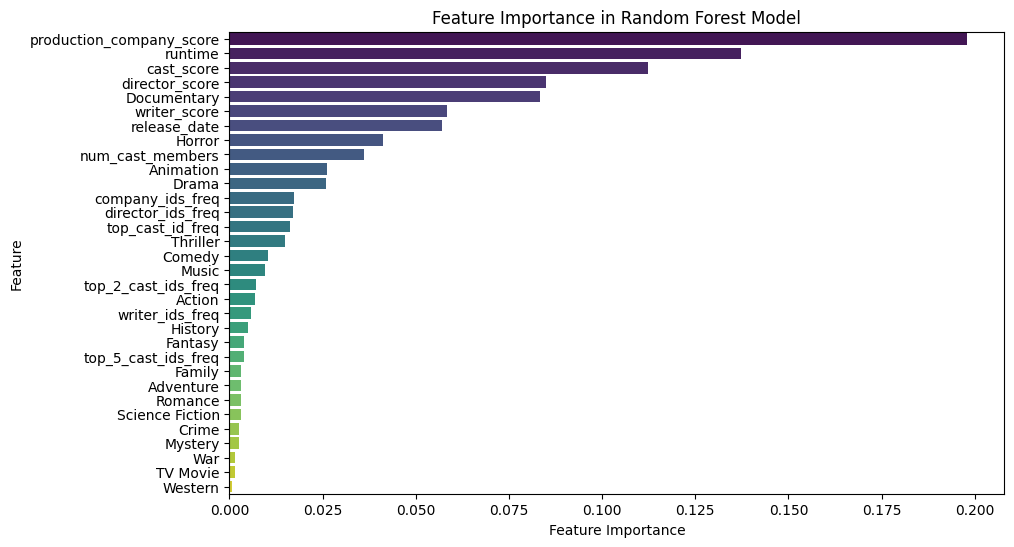

In [83]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=feature_importance_df, 
    hue="Feature", 
    palette="viridis", 
    legend=False 
)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest Model")
plt.show()

## GradientBoostingClassifier

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb.fit(X_train, y_train)

print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.8139090883566836
0.8096574957888827
